<a href="https://colab.research.google.com/github/Linuxboy2007/moex/blob/main/BlockKaczmarzLLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import linalg as LA
import time
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
def biunder(A, epsp):
    m,n = A.shape
    beta = 1.8/LA.norm(A,'fro')**2
    Em = 2*np.eye(n)
    X = beta*A
    Xold = X
    A = A.T
    err = 1e+09;it = 0
    while err > epsp:
        X = Xold@(Em - A@Xold)
        err = LA.norm(X - Xold,'fro')/LA.norm(Xold,'fro')
        Xold = X
        it = it + 1
    return X.T, it

In [140]:
def PIBR_compact( A,n, alpha, beta,bs):
    Ae = alpha*np.eye(bs)
    A1 = np.column_stack((Ae,A))
    X = beta*np.row_stack((Ae,A.T))
    Xold = X
    En = 2*np.eye(bs)
    err = 1e+10
    it = 0
    while err > 1e-07:
        B =  np.matmul(A1,Xold)
        B = En - B
        X = np.matmul(Xold,B)
        err = LA.norm(X - Xold,np.inf)/LA.norm(Xold,np.inf)
        Xold = X
        it = it + 1
    return X, it

In [141]:
def tsbk(A, f, bs, epsx, epsp, alpha):
    reer = []
    errb =[]
    m, n = A.shape
    ft = np.zeros(bs)
    mt = m + n
    theta = np.zeros((mt,2))
    Nb = int(m/bs)
    #lists for pseudoinverse
    itp = np.zeros((1,Nb))
    m1 = int(Nb*(bs+n))
    i = np.arange(0,Nb)
    p1 = bs*i; p2 = bs*(i+1)
    p1ap = (bs+n)*i; p2ap = (bs+n)*i +(n+bs)
    Ap = np.zeros((m1, bs))
    Ap2,itp2 = biunder(A.T,epsp)
    if alpha ==-1:
        alpha = np.sqrt(n)/LA.norm(Ap2,'fro')
    
    it = 0
    err = 1e+10
    Ew = alpha*np.eye(bs)
    for k in range(Nb):
        beta = 1.6/(LA.norm(A[p1[k]:p2[k],:],'fro')**2+bs*alpha**2)
        Ap[p1ap[k]:p2ap[k],:],itp[0,k] = PIBR_compact( A[p1[k]:p2[k],:], n, alpha, beta,bs)
    
    while err > epsx:
        for j in range(Nb):
            ft = f[p1[j]:p2[j],0] - (Ew.dot(theta[p1[j]:p2[j],0]) + A[p1[j]:p2[j],:].dot(theta[m:mt,0]))
            theta[p1[j]:p2[j],0] = theta[p1[j]:p2[j],0] + np.matmul(Ap[p1ap[j]:p1ap[j]+bs,:],ft)
            theta[m:mt,0] = theta[m:mt,0] + np.matmul(Ap[p1ap[j]+bs:p2ap[j],:],ft)
        theta[0:m,0] = theta[0:m,0] - Ap2@(A.T@theta[0:m,0])
        err = LA.norm(theta[:,1] - theta[:,0])/(1+LA.norm(theta[:,0]))
        reer.append(err)
        errb.append(LA.norm(theta[0:m,1])/alpha)
        theta[:,1] = theta[:,0]
        it = it + 1
    
    return theta[m:mt,1].reshape(n,1), it, itp, itp2, reer, errb

In [19]:
def mpg1(p,a,b,m):
    t = range(0,p)
    x = np.linspace(a,b,m).reshape(m,1)
    A = np.power(x,t)
    return A,x

In [175]:
nx = 10
x = np.linspace(-np.pi,np.pi,nx).T;
theta = np.array([np.pi/2, 0.1, -0.2, 0.5, 0.7, 1, -1]).reshape(7,1)
y = np.pi/2 + 0.1*np.cos(x)-0.2*np.sin(x)+ 0.5*np.cos(2*x)+0.7*np.sin(2*x)+np.cos(3*x)-np.sin(3*x);
A = np.array([np.ones(nx), np.cos(x), np.sin(x), np.cos(2*x), np.sin(2*x), np.cos(3*x),np.sin(3*x)]).T

r = null_space(A.T)
sigma = 0.2
yn =y + sigma*r[:,0]
yn = yn.reshape(nx,1)

In [176]:
xlls = LA.pinv(A)@yn
errls = LA.norm(theta - xlls)/LA.norm(theta)
print('SVD error %.4e' % errls)

SVD error 3.4515e-16


In [178]:
epsx = np.finfo(float).eps
xk, it, itp, itp2, reer, errb = tsbk(A, yn, 2, epsx, 1e-06, 1)
errxk = LA.norm(theta - xk)/LA.norm(theta)
print('Число итераций алгоритма %d' % it)
print('Среднее число итераций алгоритма БИ %d' % itp.mean())
print('Число итераций алгоритма БИ для A.T %d' % itp2)
print('BKAS error %.4e' % errxk)

Число итераций алгоритма 71
Среднее число итераций алгоритма БИ 6
Число итераций алгоритма БИ для A.T 7
BKAS error 1.9254e-16


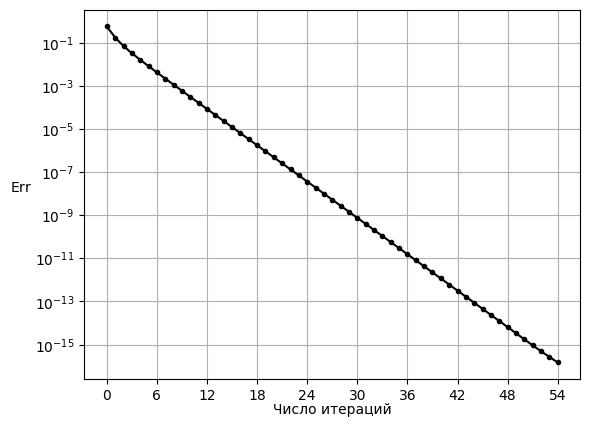

In [139]:
fig, ax1 = plt.subplots()
plt.grid(True)
ax1.plot(range(it),reer,'k.-')
#ax1.plot(range(it),errb,'k.-')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.yscale('log')
plt.ylabel('$\\mathrm{Err}$', rotation=0,labelpad=10)
plt.xlabel('Число итераций', rotation=0,labelpad=0)
plt.show()


In [167]:
p = 6; m = 100
A1,x1 = mpg1(p,0.1,1,m)
theta1 = np.array(np.linspace(0.1,1,p)).reshape(p,1)

In [168]:
LA.cond(A1)

7659.164591729507

In [169]:
r1= null_space(A1.T)
f = A1@theta1
fn = f + 0.001*r1[:,0]

In [170]:
xlls1 = LA.pinv(A1)@fn
errls1 = LA.norm(theta1 - xlls1)/LA.norm(theta1)
print('SVD error %.4e' % errls1)

SVD error 6.4793e-04


In [174]:
epsx = np.finfo(float).eps
bs = 20
xk1, it1, itp1, itp21, reer1,berr1 = tsbk(A1, fn, bs, 1e-08, 1e-06, 1)
errxk1 = LA.norm(theta1 - xk1)/LA.norm(theta1)
print('Размер блока %d' % bs)
print('Число блоков %d' % int(m/bs))
print('Число итераций алгоритма %d' % it1)
print('Среднее число итераций алгоритма БИ %d' % itp1.mean())
print('Число итераций алгоритма БИ для A.T %d' % itp21)
print('BKAS error %.4e' % errxk1)

Размер блока 20
Число блоков 5
Число итераций алгоритма 45568
Среднее число итераций алгоритма БИ 10
Число итераций алгоритма БИ для A.T 30
BKAS error 1.0300e-03
